# **Intel Image Dataset Classification by FFNN**

EE258 Project 1

Students: Rojin Zandi, Shifa Shaikh 

Importing Packages

In [ ]:
import matplotlib.pyplot as plt
import cv2
import numpy as np
import tensorflow as tf
from tensorflow import keras
import tensorflow.keras.layers as Layers
from tensorflow.keras.utils import plot_model
import tensorflow.keras.activations as Actications
from tensorflow.keras.optimizers import SGD
import tensorflow.keras.models as Models
import tensorflow.keras.optimizers as Optimizer
import tensorflow.keras.metrics as Metrics
import tensorflow.keras.utils as Utils
from keras.utils.vis_utils import model_to_dot
import os
import pathlib
from sklearn.utils import shuffle
from sklearn.metrics import confusion_matrix as CM
from sklearn.metrics import precision_score
from sklearn.metrics import recall_score
from sklearn.metrics import accuracy_score
from sklearn.metrics import f1_score
from random import randint
from IPython.display import SVG
import seaborn as sns
import matplotlib.gridspec as gridspec
import time

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
%pwd

'/content'

In [ ]:
cd 'drive' 

/content/drive


In [ ]:
cd 'My Drive/Intel_Dataset'

/content/drive/My Drive/Intel_Dataset


In [ ]:
!ls

model.png  seg_pred  seg_test  seg_train  traininghistory.pdf


In [ ]:
%pwd

'/content/drive/My Drive/Intel_Dataset'

In [ ]:
train_dir = pathlib.Path('./seg_train/seg_train')

train_image_count = len(list(train_dir.glob('*/*.jpg')))
print("Number of images in training set:",train_image_count)

Number of images in training set: 14034


In [ ]:
test_dir = pathlib.Path('./seg_test/seg_test')

test_image_count = len(list(test_dir.glob('*/*.jpg')))
print("Number of images in test set:",test_image_count)

Number of images in test set: 3000


In [ ]:
Labels = np.array([item.name for item in train_dir.glob('*') if item.name != "LICENSE.txt"])
print("Number of Labels in Intel dataset:",Labels.shape)

Number of Labels in Intel dataset: (6,)


# Preprocessing

In [ ]:
class_names = ['mountain', 'street', 'glacier', 'buildings', 'sea', 'forest']
class_names_label = {class_name:i for i, class_name in enumerate(class_names)}

nb_classes = len(class_names)

IMAGE_SIZE = (150, 150)

In [ ]:
def load_data():
    """
        Load the data:
            - 14,034 images to train the network.
            - 3,000 images to evaluate how accurately the network learned to classify images.
    """
    
    datasets = ['./seg_train/seg_train', './seg_test/seg_test']
    output = []
    
    # Iterate through training and test sets
    for dataset in datasets:
        
        images = []
        labels = []
        
        print("Loading {}".format(dataset))
        
        # Iterate through each folder corresponding to a category
        for folder in os.listdir(dataset):
            label = class_names_label[folder]
            
            # Iterate through each image in our folder
            for file in tqdm(os.listdir(os.path.join(dataset, folder))):
                
                # Get the path name of the image
                img_path = os.path.join(os.path.join(dataset, folder), file)
                
                # Open and resize the img
                image = cv2.imread(img_path)
                image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
                image = cv2.resize(image, IMAGE_SIZE) 
                
                # Append the image and its corresponding label to the output
                images.append(image)
                labels.append(label)
                
        images = np.array(images, dtype = 'float32')
        labels = np.array(labels, dtype = 'int32')   
        
        output.append((images, labels))

    return output

In [ ]:
(train_images, train_labels), (test_images, test_labels) = load_data()

  0%|          | 0/2191 [00:00<?, ?it/s]

Loading ./seg_train/seg_train


  0%|          | 0/510 [00:00<?, ?it/s]

Loading ./seg_test/seg_test


100%|██████████| 501/501 [01:50<00:00,  4.54it/s]


In [ ]:
train_images, train_labels = shuffle(train_images, train_labels, random_state=25)

In [ ]:
n_train = train_labels.shape[0]
n_test = test_labels.shape[0]

print ("Number of training examples: {}".format(n_train))
print ("Number of testing examples: {}".format(n_test))
print ("Each image is of size: {}".format(IMAGE_SIZE))

Number of training examples: 14034
Number of testing examples: 3000
Each image is of size: (150, 150)


Bar plot of the number of images in each class of the training and test set

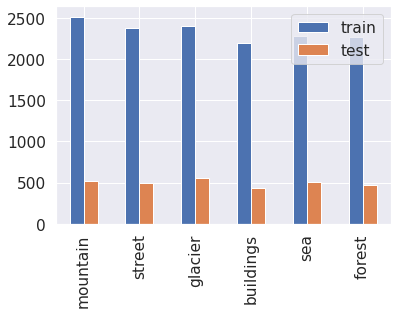

In [ ]:
import pandas as pd

_, train_counts = np.unique(train_labels, return_counts=True)
_, test_counts = np.unique(test_labels, return_counts=True)
pd.DataFrame({'train': train_counts,
                    'test': test_counts}, 
             index=class_names
            ).plot.bar()
plt.show()

Pie chart of the proportion of each observed category in the training set

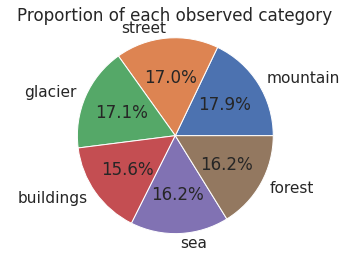

In [ ]:
plt.pie(train_counts,
        explode=(0, 0, 0, 0, 0, 0) , 
        labels=class_names,
        autopct='%1.1f%%')
plt.axis('equal')
plt.title('Proportion of each observed category')
plt.show()

In [ ]:
train_images = train_images / 255.0 
test_images = test_images / 255.0

In [ ]:
def display_examples(class_names, images, labels):
    """
        Display 25 images from the images array with its corresponding labels
    """
    
    fig = plt.figure(figsize=(10,10))
    fig.suptitle("Some examples of images of the dataset", fontsize=16)
    for i in range(25):
        plt.subplot(5,5,i+1)
        plt.xticks([])
        plt.yticks([])
        plt.grid(False)
        plt.imshow(images[i], cmap=plt.cm.binary)
        plt.xlabel(class_names[labels[i]])
    plt.show()

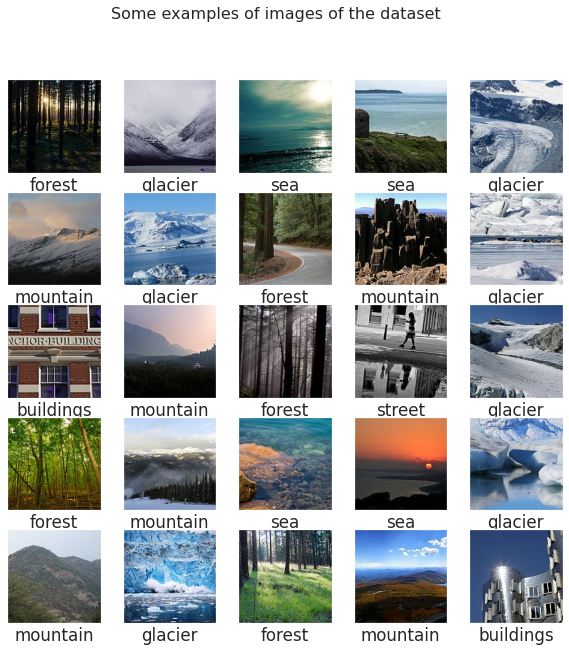

In [ ]:
display_examples(class_names, train_images, train_labels)

# MODEL 1

Fully Forward Neural Network [512-128-6]

Activation layers: ReLU, ReLU, Softmax

Applied optimization method: Stochastic Gradient Descent

Learning learning: 0.1

Number of epochs: 10

validation_split = 0.1

Without Regularization

In [ ]:
start = time.time()
l1=keras.layers.Dense(512, activation ='relu')
l2=keras.layers.Dense(128, activation='relu')
l3=keras.layers.Dense(6, activation='softmax') 
model_1 = keras.Sequential(
[
    keras.layers.Flatten(input_shape=(3,150,150)),
    l1,
    l2,
    l3     
])


sgd = SGD(learning_rate=0.1)
model_1.compile(optimizer=sgd,loss='sparse_categorical_crossentropy',metrics=['accuracy'])
EPOCHS = 10
history1 = model_1.fit(train_images, train_labels, batch_size=12, validation_split = 0.1, epochs=EPOCHS)

end = time.time()

Epoch 1/10
1053/1053 [==============================] - 7s 7ms/step - loss: 1.6297 - accuracy: 0.3063 - val_loss: 1.4422 - val_accuracy: 0.4088
Epoch 2/10
1053/1053 [==============================] - 7s 6ms/step - loss: 1.4157 - accuracy: 0.4265 - val_loss: 1.8205 - val_accuracy: 0.3070
Epoch 3/10
1053/1053 [==============================] - 7s 7ms/step - loss: 1.3511 - accuracy: 0.4628 - val_loss: 1.2967 - val_accuracy: 0.4993
Epoch 4/10
1053/1053 [==============================] - 7s 6ms/step - loss: 1.3144 - accuracy: 0.4841 - val_loss: 1.3094 - val_accuracy: 0.4808
Epoch 5/10
1053/1053 [==============================] - 7s 7ms/step - loss: 1.2871 - accuracy: 0.4949 - val_loss: 1.2538 - val_accuracy: 0.5135
Epoch 6/10
1053/1053 [==============================] - 7s 7ms/step - loss: 1.2606 - accuracy: 0.5101 - val_loss: 1.2497 - val_accuracy: 0.5121
Epoch 7/10
1053/1053 [==============================] - 7s 6ms/step - loss: 1.2426 - accuracy: 0.5177 - val_loss: 1.2227 - val_accuracy:

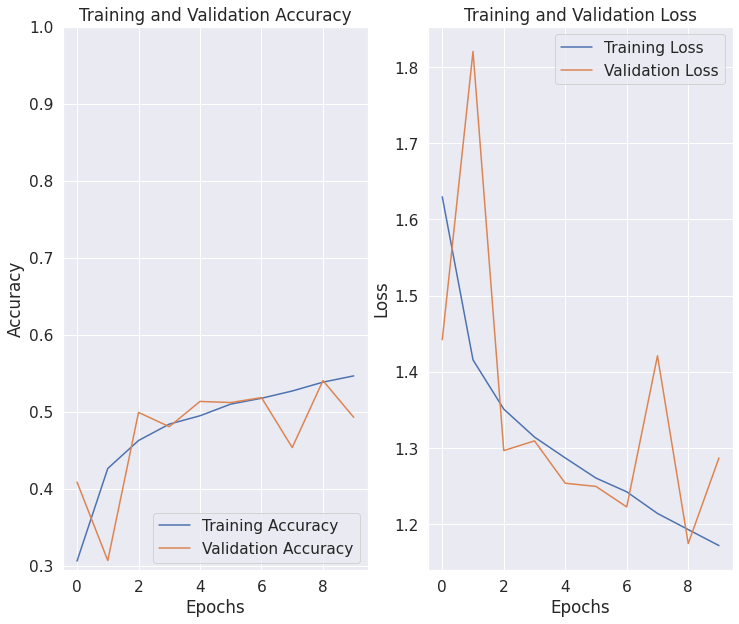

In [ ]:
#Plotting Accuracy and Loss of Training and Validation set
def plot_history(history, metric, val_metric,EPOCHS):
  acc = history.history[metric]
  val_acc = history.history[val_metric]

  loss=history.history['loss']
  val_loss=history.history['val_loss']

  epochs_range = range(EPOCHS)

  fig=plt.figure(figsize=(12, 10))
  plt.subplot(1, 2, 1)
  plt.plot(epochs_range, acc, label='Training Accuracy')
  plt.plot(epochs_range, val_acc, label='Validation Accuracy')
  plt.legend(loc='lower right')
  plt.xlabel("Epochs")
  plt.ylabel("Accuracy")
  plt.ylim([min(plt.ylim()),1])
  plt.grid(True)
  plt.title('Training and Validation Accuracy')

  plt.subplot(1, 2, 2)
  plt.plot(epochs_range, loss, label='Training Loss')
  plt.plot(epochs_range, val_loss, label='Validation Loss')
  plt.legend(loc='upper right')
  plt.xlabel("Epochs")
  plt.ylabel("Loss")
  plt.grid(True)
  plt.title('Training and Validation Loss')
  plt.show()
  #fig.savefig('traininghistory.pdf')


plot_history(history1,'accuracy','val_accuracy',EPOCHS)

In [ ]:
y_pred1=model_1.predict_classes(test_images)
test_loss, test_acc = model_1.evaluate(test_images,  test_labels, verbose=2)

print('\nTest accuracy:', test_acc)

94/94 - 1s - loss: 1.3314 - accuracy: 0.4783

Test accuracy: 0.47833332419395447


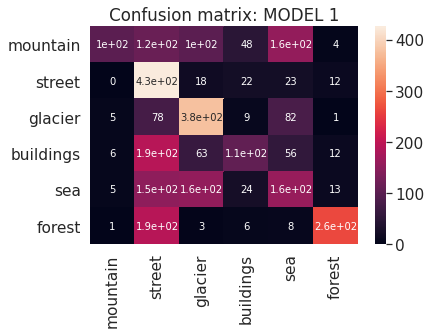


 Model-1 Recall_score
 [0.19047619 0.8502994  0.6835443  0.24485126 0.31372549 0.55696203]

 Model-1 Accuracy_score
 0.47833333333333333

 Model-1 F1_score
 [0.31152648 0.51356239 0.59527559 0.32771822 0.32128514 0.67692308]


In [ ]:

CM = confusion_matrix(test_labels, y_pred1)
ax = plt.axes()
sn.heatmap(CM, annot=True, 
           annot_kws={"size": 10}, 
           xticklabels=class_names, 
           yticklabels=class_names, ax = ax)
ax.set_title('Confusion matrix: MODEL 1')
plt.show()

precision_scoreM1=precision_score(test_labels, y_pred1, average=None)
#print("\n Model-1 Precision_score\n", precision_scoreM1)

recall_scoreM1=recall_score(test_labels, y_pred1, average=None)
print("\n Model-1 Recall_score\n",recall_scoreM1)

accuracy_scoreM1=accuracy_score(test_labels, y_pred1)
print("\n Model-1 Accuracy_score\n",accuracy_scoreM1)

f1_scoreM1=f1_score(test_labels, y_pred1, average=None)
print("\n Model-1 F1_score\n",f1_scoreM1)

**MODEL 1.2**

Fully Forward Neural Network [512-256-128-6]

Activation layers: ReLU, ReLU, ReLU, Softmax

Applied optimization method: Stochastic Gradient Descent

Learning learning: 0.1

Number of epochs: 10

validation_split = 0.1

Without Regularization

In [ ]:
start = time.time()
l1=keras.layers.Dense(512, activation ='relu')
l2=keras.layers.Dense(256, activation ='relu')
l3=keras.layers.Dense(128, activation='relu')
l4=keras.layers.Dense(6, activation='softmax') 
model_12 = keras.Sequential(
[
    keras.layers.Flatten(input_shape=(3,150,150)),
    l1,
    l2,
    l3,
    l4     
])


sgd = SGD(learning_rate=0.1)
model_12.compile(optimizer=sgd,loss='sparse_categorical_crossentropy',metrics=['accuracy'])
EPOCHS = 10
history12 = model_12.fit(train_images, train_labels, batch_size=12, validation_split = 0.1, epochs=EPOCHS)

end = time.time()

Epoch 1/10
1053/1053 [==============================] - 7s 7ms/step - loss: 1.6586 - accuracy: 0.2831 - val_loss: 1.4725 - val_accuracy: 0.3960
Epoch 2/10
1053/1053 [==============================] - 7s 7ms/step - loss: 1.4471 - accuracy: 0.4113 - val_loss: 1.5740 - val_accuracy: 0.3504
Epoch 3/10
1053/1053 [==============================] - 7s 7ms/step - loss: 1.3658 - accuracy: 0.4548 - val_loss: 1.3240 - val_accuracy: 0.4772
Epoch 4/10
1053/1053 [==============================] - 7s 7ms/step - loss: 1.3244 - accuracy: 0.4808 - val_loss: 1.2950 - val_accuracy: 0.4751
Epoch 5/10
1053/1053 [==============================] - 7s 7ms/step - loss: 1.3003 - accuracy: 0.4855 - val_loss: 1.2670 - val_accuracy: 0.4979
Epoch 6/10
1053/1053 [==============================] - 7s 7ms/step - loss: 1.2740 - accuracy: 0.5010 - val_loss: 1.2151 - val_accuracy: 0.5221
Epoch 7/10
1053/1053 [==============================] - 7s 7ms/step - loss: 1.2560 - accuracy: 0.5070 - val_loss: 1.2528 - val_accuracy:

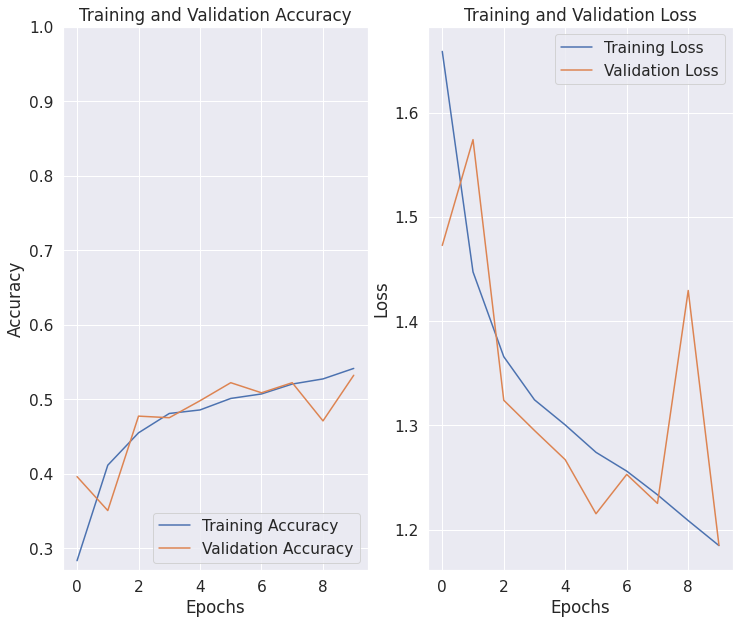

In [ ]:
plot_history(history12,'accuracy','val_accuracy',EPOCHS)

In [ ]:
y_pred12=model_12.predict_classes(test_images)
test_loss, test_acc = model_12.evaluate(test_images,  test_labels, verbose=2)

print('\nTest accuracy:', test_acc)

94/94 - 1s - loss: 1.1951 - accuracy: 0.5353

Test accuracy: 0.5353333353996277


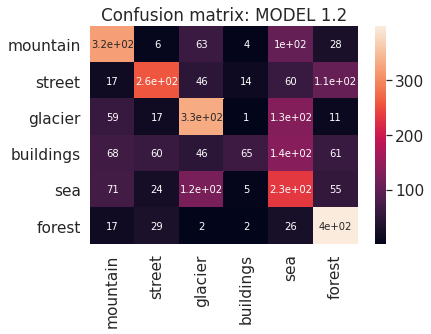


 Recall_score
 [0.60952381 0.51497006 0.60036166 0.14874142 0.45686275 0.83966245]

 Accuracy_score
 0.5353333333333333

  F1_score
 [0.59424327 0.57653631 0.57044674 0.24621212 0.38736492 0.70255958]


In [ ]:
CM = confusion_matrix(test_labels, y_pred12)
ax = plt.axes()
sn.heatmap(CM, annot=True, 
           annot_kws={"size": 10}, 
           xticklabels=class_names, 
           yticklabels=class_names, ax = ax)
ax.set_title('Confusion matrix: MODEL 1.2')
plt.show()

precision_scoreM1=precision_score(test_labels, y_pred12, average=None)
#print("\n Model-1 Precision_score\n", precision_scoreM1)

recall_scoreM1=recall_score(test_labels, y_pred12, average=None)
print("\n Recall_score\n",recall_scoreM1)

accuracy_scoreM1=accuracy_score(test_labels, y_pred12)
print("\n Accuracy_score\n",accuracy_scoreM1)

f1_scoreM1=f1_score(test_labels, y_pred12, average=None)
print("\n  F1_score\n",f1_scoreM1)

# MODEL 2

Fully Forward Neural Network [512-128-6]

Activation layers: ReLU, ReLU, Softmax

Applied optimization method: Stochastic Gradient Descent

**Learning learning: 0.001**

Number of epochs: 10

validation_split = 0.1

Without Regularization

In [ ]:
start = time.time()
l1=keras.layers.Dense(512, activation ='relu')
#l2=keras.layers.Dense(256, activation ='relu')
l3=keras.layers.Dense(128, activation='relu')
l4=keras.layers.Dense(6, activation='softmax') 
model_2 = keras.Sequential(
[
    keras.layers.Flatten(input_shape=(3,150,150)),
    l1,
    #l2,
    l3,
    l4     
])


sgd = SGD(learning_rate=0.001)
model_2.compile(optimizer=sgd,loss='sparse_categorical_crossentropy',metrics=['accuracy'])
EPOCHS = 10
history2 = model_2.fit(train_images, train_labels, batch_size=12, validation_split = 0.1, epochs=EPOCHS)

end = time.time()

Epoch 1/10
1053/1053 [==============================] - 7s 7ms/step - loss: 1.7903 - accuracy: 0.1968 - val_loss: 1.7888 - val_accuracy: 0.1823
Epoch 2/10
1053/1053 [==============================] - 7s 6ms/step - loss: 1.7883 - accuracy: 0.1952 - val_loss: 1.7870 - val_accuracy: 0.1766
Epoch 3/10
1053/1053 [==============================] - 7s 6ms/step - loss: 1.7866 - accuracy: 0.1888 - val_loss: 1.7850 - val_accuracy: 0.1859
Epoch 4/10
1053/1053 [==============================] - 7s 6ms/step - loss: 1.7847 - accuracy: 0.2010 - val_loss: 1.7830 - val_accuracy: 0.1866
Epoch 5/10
1053/1053 [==============================] - 7s 6ms/step - loss: 1.7829 - accuracy: 0.2045 - val_loss: 1.7809 - val_accuracy: 0.1866
Epoch 6/10
1053/1053 [==============================] - 7s 6ms/step - loss: 1.7808 - accuracy: 0.2139 - val_loss: 1.7787 - val_accuracy: 0.1916
Epoch 7/10
1053/1053 [==============================] - 7s 6ms/step - loss: 1.7787 - accuracy: 0.2124 - val_loss: 1.7763 - val_accuracy:

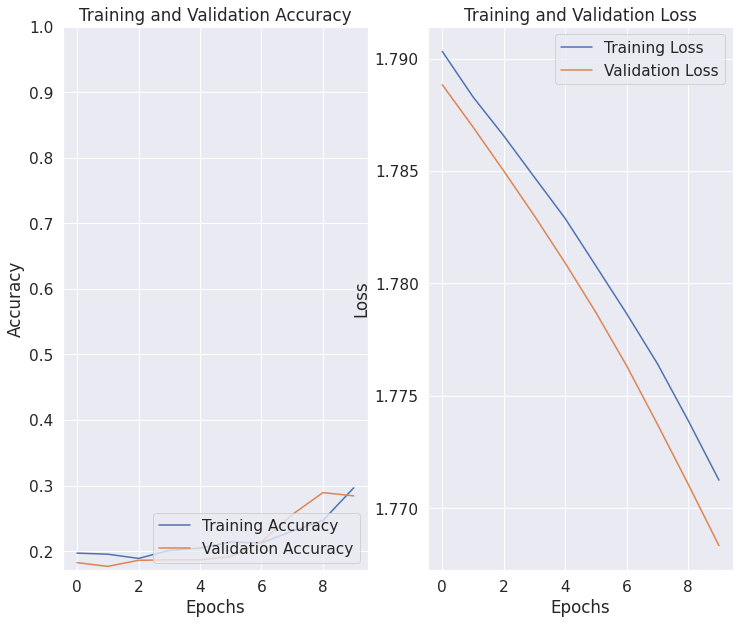

In [ ]:
plot_history(history2,'accuracy','val_accuracy',EPOCHS)

In [ ]:
y_pred2=model_2.predict_classes(test_images)
test_loss, test_acc = model_2.evaluate(test_images,  test_labels, verbose=2)

print('\nTest accuracy:', test_acc)

94/94 - 1s - loss: 1.7696 - accuracy: 0.2820

Test accuracy: 0.28200000524520874


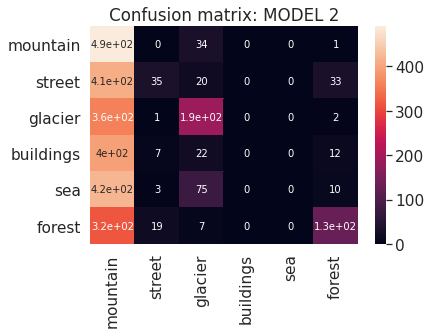


 Recall_score
 [0.93333333 0.06986028 0.34358047 0.         0.         0.27637131]

  Accuracy_score
 0.282

 F1_score
 [0.33527198 0.12367491 0.42175361 0.         0.         0.39517345]


/usr/local/lib/python3.6/dist-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


In [ ]:
CM = confusion_matrix(test_labels, y_pred2)
ax = plt.axes()
sn.heatmap(CM, annot=True, 
           annot_kws={"size": 10}, 
           xticklabels=class_names, 
           yticklabels=class_names, ax = ax)
ax.set_title('Confusion matrix: MODEL 2')
plt.show()

precision_scoreM1=precision_score(test_labels, y_pred2, average=None)
#print("\n Model-1 Precision_score\n", precision_scoreM1)

recall_scoreM1=recall_score(test_labels, y_pred2, average=None)
print("\n Recall_score\n",recall_scoreM1)

accuracy_scoreM1=accuracy_score(test_labels, y_pred2)
print("\n  Accuracy_score\n",accuracy_scoreM1)

f1_scoreM1=f1_score(test_labels, y_pred2, average=None)
print("\n F1_score\n",f1_scoreM1)

**MODEL 2.1**


Fully Forward Neural Network [512-128-6]

Activation layers: ReLU, ReLU, Softmax

**Applied optimization method: Adam**

**Learning learning: 0.001**

Number of epochs: 10

validation_split = 0.1

Without Regularization

In [ ]:
start = time.time()
l1=keras.layers.Dense(512, activation ='relu')
#l2=keras.layers.Dense(256, activation ='relu')
l3=keras.layers.Dense(128, activation='relu')
l4=keras.layers.Dense(6, activation='softmax') 
model_21 = keras.Sequential(
[
    keras.layers.Flatten(input_shape=(3,150,150)),
    l1,
    #l2,
    l3,
    l4     
])

opt = tf.keras.optimizers.Adam(learning_rate=0.001)
model_21.compile(optimizer=opt,loss='sparse_categorical_crossentropy',metrics=['accuracy'])
EPOCHS = 10
history21 = model_21.fit(train_images, train_labels, batch_size=12, validation_split = 0.1, epochs=EPOCHS)

end = time.time()

Epoch 1/10
1053/1053 [==============================] - 11s 10ms/step - loss: 1.3517 - accuracy: 0.4685 - val_loss: 1.2052 - val_accuracy: 0.5342
Epoch 2/10
1053/1053 [==============================] - 11s 10ms/step - loss: 1.1678 - accuracy: 0.5461 - val_loss: 1.1201 - val_accuracy: 0.5691
Epoch 3/10
1053/1053 [==============================] - 10s 10ms/step - loss: 1.0866 - accuracy: 0.5806 - val_loss: 1.0812 - val_accuracy: 0.6033
Epoch 4/10
1053/1053 [==============================] - 11s 10ms/step - loss: 1.0382 - accuracy: 0.6013 - val_loss: 1.0873 - val_accuracy: 0.5826
Epoch 5/10
1053/1053 [==============================] - 11s 10ms/step - loss: 0.9956 - accuracy: 0.6238 - val_loss: 1.0654 - val_accuracy: 0.6033
Epoch 6/10
1053/1053 [==============================] - 11s 10ms/step - loss: 0.9565 - accuracy: 0.6363 - val_loss: 1.0695 - val_accuracy: 0.6047
Epoch 7/10
1053/1053 [==============================] - 11s 10ms/step - loss: 0.9215 - accuracy: 0.6508 - val_loss: 1.0301 -

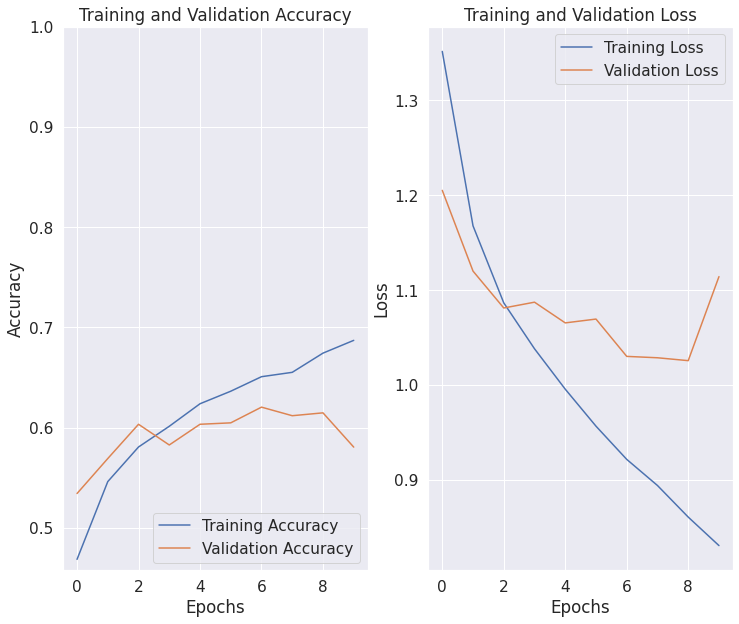

In [ ]:
plot_history(history21,'accuracy','val_accuracy',EPOCHS)

In [ ]:
y_pred21=model_21.predict_classes(test_images)
test_loss, test_acc = model_21.evaluate(test_images,  test_labels, verbose=2)

print('\nTest accuracy:', test_acc)

94/94 - 1s - loss: 1.1322 - accuracy: 0.5757

Test accuracy: 0.5756666660308838


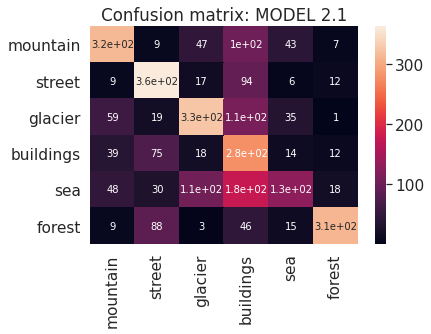


 Recall_score
 [0.6        0.7245509  0.59132007 0.63844394 0.25490196 0.66033755]

 Accuracy_score
 0.5756666666666667

 F1_score
 [0.62749004 0.66912442 0.61064426 0.4464     0.34528552 0.7479092 ]


In [ ]:
CM = confusion_matrix(test_labels, y_pred21)
ax = plt.axes()
sn.heatmap(CM, annot=True, 
           annot_kws={"size": 10}, 
           xticklabels=class_names, 
           yticklabels=class_names, ax = ax)
ax.set_title('Confusion matrix: MODEL 2.1')
plt.show()

precision_scoreM21=precision_score(test_labels, y_pred21, average=None)


recall_scoreM21=recall_score(test_labels, y_pred21, average=None)
print("\n Recall_score\n",recall_scoreM21)

accuracy_scoreM21=accuracy_score(test_labels, y_pred21)
print("\n Accuracy_score\n",accuracy_scoreM21)

f1_scoreM21=f1_score(test_labels, y_pred21, average=None)
print("\n F1_score\n",f1_scoreM21)

# MODEL 3

Fully Forward Neural Network [512-256-128-6]

Activation layers: ReLU, ReLU, ReLU, Softmax

Applied optimization method: Adam

Learning learning: 0.001

Number of epochs: 10

**validation_split = 0.2**

Without Regularization

In [ ]:
start = time.time()
l1=keras.layers.Dense(512, activation ='relu')
l2=keras.layers.Dense(256, activation ='relu')
l3=keras.layers.Dense(128, activation='relu')
l4=keras.layers.Dense(6, activation='softmax') 
model_3 = keras.Sequential(
[
    keras.layers.Flatten(input_shape=(3,150,150)),
    l1,
    l2,
    l3,
    l4     
])

opt = tf.keras.optimizers.Adam(learning_rate=0.001)
model_3.compile(optimizer=opt,loss='sparse_categorical_crossentropy',metrics=['accuracy'])
EPOCHS = 10
history3 = model_3.fit(train_images, train_labels, batch_size=12, validation_split = 0.2, epochs=EPOCHS)

end = time.time()

Epoch 1/10
936/936 [==============================] - 10s 11ms/step - loss: 1.3719 - accuracy: 0.4533 - val_loss: 1.2656 - val_accuracy: 0.4988
Epoch 2/10
936/936 [==============================] - 10s 11ms/step - loss: 1.1817 - accuracy: 0.5358 - val_loss: 1.1497 - val_accuracy: 0.5607
Epoch 3/10
936/936 [==============================] - 10s 11ms/step - loss: 1.1196 - accuracy: 0.5660 - val_loss: 1.1421 - val_accuracy: 0.5622
Epoch 4/10
936/936 [==============================] - 10s 11ms/step - loss: 1.0556 - accuracy: 0.5931 - val_loss: 1.1182 - val_accuracy: 0.5739
Epoch 5/10
936/936 [==============================] - 10s 11ms/step - loss: 1.0222 - accuracy: 0.6096 - val_loss: 1.0936 - val_accuracy: 0.5839
Epoch 6/10
936/936 [==============================] - 10s 11ms/step - loss: 0.9844 - accuracy: 0.6213 - val_loss: 1.0940 - val_accuracy: 0.5835
Epoch 7/10
936/936 [==============================] - 10s 11ms/step - loss: 0.9410 - accuracy: 0.6425 - val_loss: 1.0802 - val_accuracy:

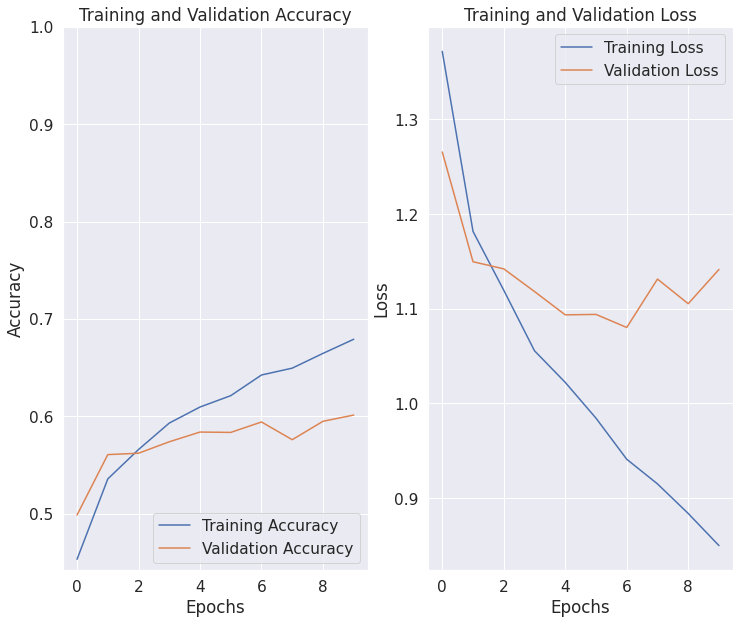

In [ ]:
plot_history(history3,'accuracy','val_accuracy',EPOCHS)

In [ ]:
y_pred3=model_3.predict_classes(test_images)
test_loss, test_acc = model_3.evaluate(test_images,  test_labels, verbose=2)

print('\nTest accuracy:', test_acc)

94/94 - 0s - loss: 1.1697 - accuracy: 0.5893

Test accuracy: 0.5893333554267883


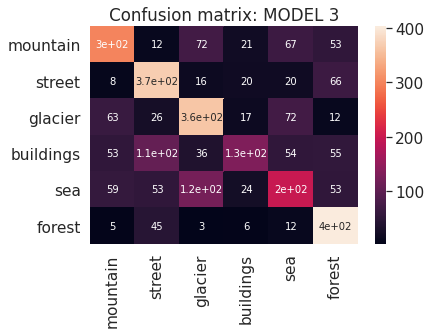


 Recall_score
 [0.57142857 0.74051896 0.65641953 0.3020595  0.39019608 0.85021097]

 Accuracy_score
 0.5893333333333334

 F1_score
 [0.5923001  0.66547085 0.62317597 0.40182648 0.4261242  0.72222222]


In [ ]:
CM = confusion_matrix(test_labels, y_pred3)
ax = plt.axes()
sn.heatmap(CM, annot=True, 
           annot_kws={"size": 10}, 
           xticklabels=class_names, 
           yticklabels=class_names, ax = ax)
ax.set_title('Confusion matrix: MODEL 3')
plt.show()

precision_scoreM3=precision_score(test_labels, y_pred3, average=None)


recall_scoreM3=recall_score(test_labels, y_pred3, average=None)
print("\n Recall_score\n",recall_scoreM3)

accuracy_scoreM3=accuracy_score(test_labels, y_pred3)
print("\n Accuracy_score\n",accuracy_scoreM3)

f1_scoreM3=f1_score(test_labels, y_pred3, average=None)
print("\n F1_score\n",f1_scoreM3)

# MODEL 4

Fully Forward Neural Network [512-256-128-6]

Activation layers: ReLU, ReLU, tanh, Softmax

Applied optimization method: Adam

Learning rate: 0.001

Number of epochs: 10

validation_split = 0.2

Without Regularization

In [ ]:
start = time.time()
l1=keras.layers.Dense(512, activation ='relu')
l2=keras.layers.Dense(256, activation ='tanh')
l3=keras.layers.Dense(128, activation='relu')
l4=keras.layers.Dense(6, activation='softmax') 
model_4 = keras.Sequential(
[
    keras.layers.Flatten(input_shape=(3,150,150)),
    l1,
    l2,
    l3,
    l4     
])

opt = tf.keras.optimizers.Adam(learning_rate=0.001)
model_4.compile(optimizer=opt,loss='sparse_categorical_crossentropy',metrics=['accuracy'])
EPOCHS = 10
history4 = model_4.fit(train_images, train_labels, batch_size=12, validation_split = 0.2, epochs=EPOCHS)

end = time.time()

Epoch 1/10
936/936 [==============================] - 11s 11ms/step - loss: 1.3644 - accuracy: 0.4529 - val_loss: 1.2483 - val_accuracy: 0.4817
Epoch 2/10
936/936 [==============================] - 10s 11ms/step - loss: 1.1771 - accuracy: 0.5426 - val_loss: 1.1577 - val_accuracy: 0.5458
Epoch 3/10
936/936 [==============================] - 10s 11ms/step - loss: 1.1118 - accuracy: 0.5724 - val_loss: 1.1369 - val_accuracy: 0.5664
Epoch 4/10
936/936 [==============================] - 10s 11ms/step - loss: 1.0610 - accuracy: 0.5894 - val_loss: 1.1513 - val_accuracy: 0.5675
Epoch 5/10
936/936 [==============================] - 10s 11ms/step - loss: 1.0207 - accuracy: 0.6140 - val_loss: 1.1315 - val_accuracy: 0.5543
Epoch 6/10
936/936 [==============================] - 10s 11ms/step - loss: 0.9808 - accuracy: 0.6288 - val_loss: 1.0556 - val_accuracy: 0.5989
Epoch 7/10
936/936 [==============================] - 10s 11ms/step - loss: 0.9486 - accuracy: 0.6372 - val_loss: 1.1707 - val_accuracy:

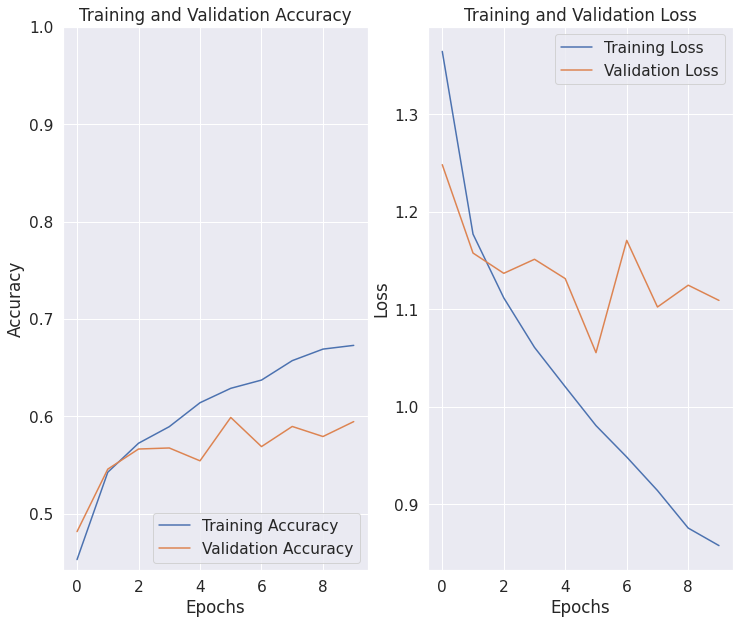

In [ ]:
plot_history(history4,'accuracy','val_accuracy',EPOCHS)

In [ ]:
y_pred4=model_4.predict_classes(test_images)
test_loss, test_acc = model_4.evaluate(test_images,  test_labels, verbose=2)

print('\nTest accuracy:', test_acc)

94/94 - 1s - loss: 1.1465 - accuracy: 0.5747

Test accuracy: 0.5746666789054871


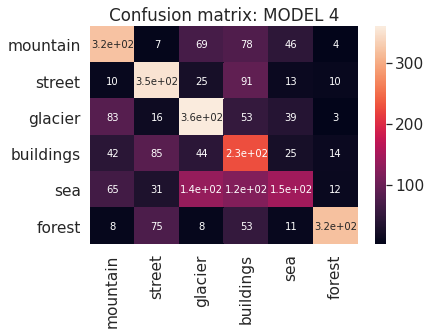


 Recall_score
 [0.61142857 0.70259481 0.64918626 0.5194508  0.28627451 0.67299578]

 Accuracy_score
 0.5746666666666667

 F1_score
 [0.60910816 0.65979381 0.60134003 0.42870633 0.36962025 0.76315789]


In [ ]:
CM = confusion_matrix(test_labels, y_pred4)
ax = plt.axes()
sn.heatmap(CM, annot=True, 
           annot_kws={"size": 10}, 
           xticklabels=class_names, 
           yticklabels=class_names, ax = ax)
ax.set_title('Confusion matrix: MODEL 4')
plt.show()

precision_scoreM4=precision_score(test_labels, y_pred4, average=None)


recall_scoreM4=recall_score(test_labels, y_pred4, average=None)
print("\n Recall_score\n",recall_scoreM4)

accuracy_scoreM4=accuracy_score(test_labels, y_pred4)
print("\n Accuracy_score\n",accuracy_scoreM4)

f1_scoreM4=f1_score(test_labels, y_pred4, average=None)
print("\n F1_score\n",f1_scoreM4)

# MODEL 5

Fully Forward Neural Network [512-256-128-6]

Activation layers: ReLU, ReLU, ReLU, Softmax

Applied optimization method: Adam

Learning learning: 0.001

**Number of epochs: 15**

validation_split = 0.2

Without Regularization

In [ ]:
start = time.time()
l1=keras.layers.Dense(256, activation ='relu')
l2=keras.layers.Dense(256, activation ='relu')
l3=keras.layers.Dense(128, activation='relu')
l4=keras.layers.Dense(6, activation='softmax') 
model_5 = keras.Sequential(
[
    keras.layers.Flatten(input_shape=(3,150,150)),
    l1,
    l2,
    l3,
    l4     
])

opt = tf.keras.optimizers.Adam(learning_rate=0.001)
model_5.compile(optimizer=opt,loss='sparse_categorical_crossentropy',metrics=['accuracy'])
EPOCHS = 15
history5 = model_5.fit(train_images, train_labels, batch_size=12, validation_split = 0.2, epochs=EPOCHS)

end = time.time()

Epoch 1/15
936/936 [==============================] - 7s 8ms/step - loss: 1.3751 - accuracy: 0.4524 - val_loss: 1.2792 - val_accuracy: 0.4977
Epoch 2/15
936/936 [==============================] - 7s 7ms/step - loss: 1.1618 - accuracy: 0.5507 - val_loss: 1.2131 - val_accuracy: 0.5390
Epoch 3/15
936/936 [==============================] - 7s 7ms/step - loss: 1.0955 - accuracy: 0.5785 - val_loss: 1.1703 - val_accuracy: 0.5540
Epoch 4/15
936/936 [==============================] - 7s 7ms/step - loss: 1.0479 - accuracy: 0.5983 - val_loss: 1.1466 - val_accuracy: 0.5632
Epoch 5/15
936/936 [==============================] - 7s 7ms/step - loss: 1.0151 - accuracy: 0.6118 - val_loss: 1.0662 - val_accuracy: 0.5903
Epoch 6/15
936/936 [==============================] - 7s 7ms/step - loss: 0.9740 - accuracy: 0.6287 - val_loss: 1.1150 - val_accuracy: 0.5839
Epoch 7/15
936/936 [==============================] - 7s 7ms/step - loss: 0.9410 - accuracy: 0.6400 - val_loss: 1.0500 - val_accuracy: 0.5964
Epoch 

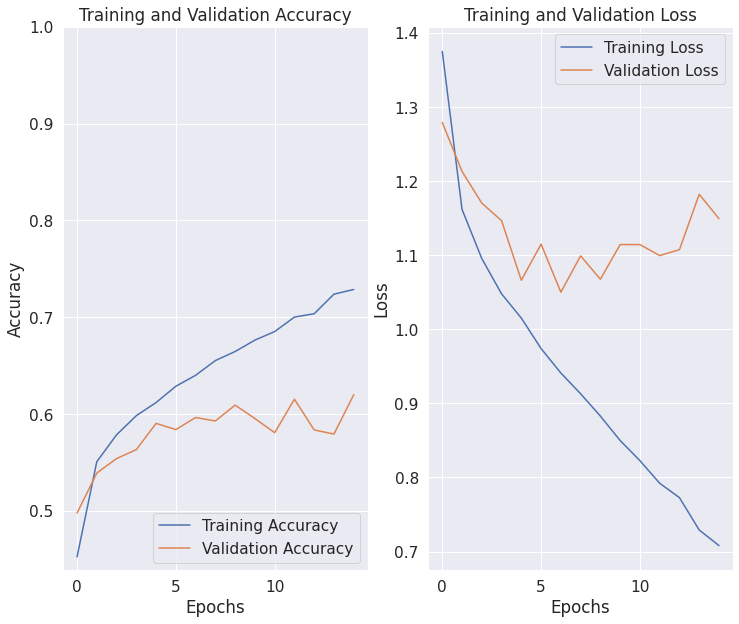

In [ ]:
plot_history(history5,'accuracy','val_accuracy',EPOCHS)

In [ ]:
y_pred5=model_5.predict_classes(test_images)
test_loss, test_acc = model_5.evaluate(test_images,  test_labels, verbose=2)

print('\nTest accuracy:', test_acc)

94/94 - 0s - loss: 1.1850 - accuracy: 0.6093

Test accuracy: 0.609333336353302


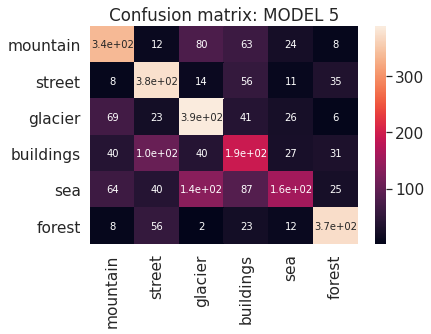


 Recall_score
 [0.64380952 0.75249501 0.70162749 0.44393593 0.30980392 0.78691983]

 Accuracy_score
 0.6093333333333333

 F1_score
 [0.64258555 0.67684022 0.63973619 0.43063263 0.41145833 0.78361345]


In [ ]:
CM = confusion_matrix(test_labels, y_pred5)
ax = plt.axes()
sn.heatmap(CM, annot=True, 
           annot_kws={"size": 10}, 
           xticklabels=class_names, 
           yticklabels=class_names, ax = ax)
ax.set_title('Confusion matrix: MODEL 5')
plt.show()

precision_scoreM5=precision_score(test_labels, y_pred5, average=None)


recall_scoreM5=recall_score(test_labels, y_pred5, average=None)
print("\n Recall_score\n",recall_scoreM5)

accuracy_scoreM5=accuracy_score(test_labels, y_pred5)
print("\n Accuracy_score\n",accuracy_scoreM5)

f1_scoreM5=f1_score(test_labels, y_pred5, average=None)
print("\n F1_score\n",f1_scoreM5)

# MODEL 6

Fully Forward Neural Network [512-256-128-6]

Activation layers: ReLU, ReLU, ReLU, Softmax

Applied optimization method: Adam

Learning learning: 0.001

Number of epochs: 15

validation_split = 0.2

**Regularization: L1**

In [ ]:
start = time.time()
l1=keras.layers.Dense(512, activation ='relu', kernel_initializer= 'ones', kernel_regularizer=tf.keras.regularizers.L1(0.1))
l2=keras.layers.Dense(256, activation ='relu')
l3=keras.layers.Dense(128, activation='relu')
l4=keras.layers.Dense(6, activation='softmax') 
model_6 = keras.Sequential(
[
    keras.layers.Flatten(input_shape=(3,150,150)),
    l1,
    l2,
    l3,
    l4     
])

opt = tf.keras.optimizers.Adam(learning_rate=0.001)
model_6.compile(optimizer=opt,loss='sparse_categorical_crossentropy',metrics=['accuracy'])
EPOCHS = 15
history6 = model_6.fit(train_images, train_labels, batch_size=12, validation_split = 0.2, epochs=EPOCHS)

end = time.time()

Epoch 1/15
936/936 [==============================] - 17s 18ms/step - loss: 1841062.7500 - accuracy: 0.1783 - val_loss: 221209.9844 - val_accuracy: 0.2287
Epoch 2/15
936/936 [==============================] - 17s 18ms/step - loss: 8771.5498 - accuracy: 0.2189 - val_loss: 781.4581 - val_accuracy: 0.2366
Epoch 3/15
936/936 [==============================] - 16s 17ms/step - loss: 785.5995 - accuracy: 0.2070 - val_loss: 613.3883 - val_accuracy: 0.1585
Epoch 4/15
936/936 [==============================] - 16s 17ms/step - loss: 622.3769 - accuracy: 0.1892 - val_loss: 494.1798 - val_accuracy: 0.1585
Epoch 5/15
936/936 [==============================] - 16s 17ms/step - loss: 486.4523 - accuracy: 0.1842 - val_loss: 408.6373 - val_accuracy: 0.1810
Epoch 6/15
936/936 [==============================] - 16s 17ms/step - loss: 405.9494 - accuracy: 0.1696 - val_loss: 379.0338 - val_accuracy: 0.1838
Epoch 7/15
936/936 [==============================] - 16s 17ms/step - loss: 394.6325 - accuracy: 0.1774 

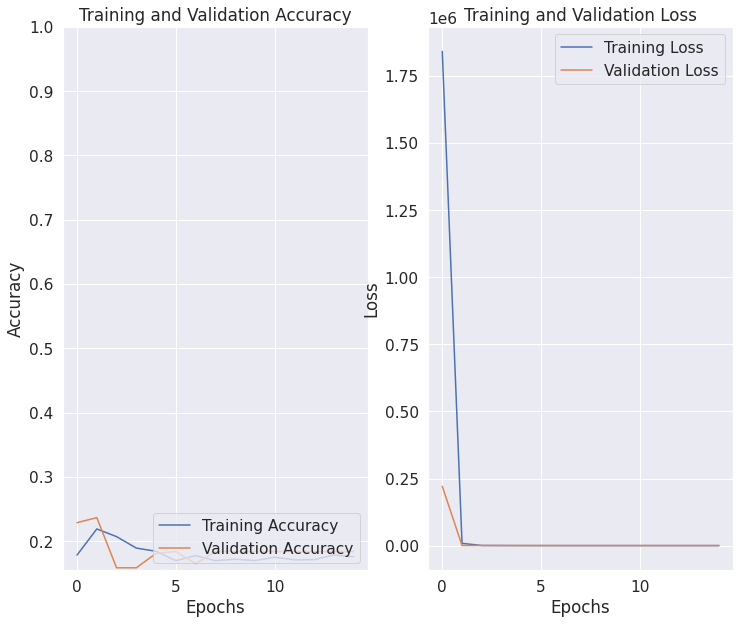

In [ ]:
plot_history(history6,'accuracy','val_accuracy',EPOCHS)

In [ ]:
y_pred6=model_6.predict_classes(test_images)
test_loss, test_acc = model_6.evaluate(test_images,  test_labels, verbose=2)

print('\nTest accuracy:', test_acc)

94/94 - 1s - loss: 374.2929 - accuracy: 0.1750

Test accuracy: 0.17499999701976776


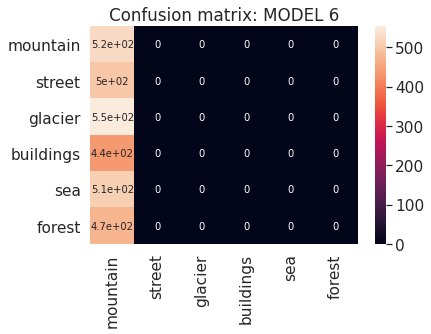


 Recall_score
 [1. 0. 0. 0. 0. 0.]

 Accuracy_score
 0.6093333333333333

 F1_score
 [0.29787234 0.         0.         0.         0.         0.        ]


/usr/local/lib/python3.6/dist-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


In [ ]:
CM = confusion_matrix(test_labels, y_pred6)
ax = plt.axes()
sn.heatmap(CM, annot=True, 
           annot_kws={"size": 10}, 
           xticklabels=class_names, 
           yticklabels=class_names, ax = ax)
ax.set_title('Confusion matrix: MODEL 6')
plt.show()

precision_scoreM6=precision_score(test_labels, y_pred6, average=None)


recall_scoreM6=recall_score(test_labels, y_pred6, average=None)
print("\n Recall_score\n",recall_scoreM6)

accuracy_scoreM6=accuracy_score(test_labels, y_pred6)
print("\n Accuracy_score\n",accuracy_scoreM5)

f1_scoreM6=f1_score(test_labels, y_pred6, average=None)
print("\n F1_score\n",f1_scoreM6)

**MODEL 6.1**

Fully Forward Neural Network [512-256-128-6]

Activation layers: ReLU, ReLU, ReLU, Softmax

Applied optimization method: Adam

Learning learning: 0.001

Number of epochs: 15

validation_split = 0.2

**Regularization: L2**

In [ ]:
start = time.time()
l1=keras.layers.Dense(512, activation ='relu', kernel_initializer= 'ones', kernel_regularizer=tf.keras.regularizers.L2(0.1))
l2=keras.layers.Dense(256, activation ='relu')
l3=keras.layers.Dense(128, activation='relu')
l4=keras.layers.Dense(6, activation='softmax') 
model_61 = keras.Sequential(
[
    keras.layers.Flatten(input_shape=(3,150,150)),
    l1,
    l2,
    l3,
    l4     
])

opt = tf.keras.optimizers.Adam(learning_rate=0.001)
model_61.compile(optimizer=opt,loss='sparse_categorical_crossentropy',metrics=['accuracy'])
EPOCHS = 15
history61 = model_61.fit(train_images, train_labels, batch_size=12, validation_split = 0.2, epochs=EPOCHS)

end = time.time()

Epoch 1/15
936/936 [==============================] - 16s 17ms/step - loss: 1412779.1250 - accuracy: 0.1623 - val_loss: 287930.7812 - val_accuracy: 0.2725
Epoch 2/15
936/936 [==============================] - 16s 17ms/step - loss: 75939.1953 - accuracy: 0.2238 - val_loss: 3395.2188 - val_accuracy: 0.2843
Epoch 3/15
936/936 [==============================] - 16s 17ms/step - loss: 535.9663 - accuracy: 0.3052 - val_loss: 3.0844 - val_accuracy: 0.2875
Epoch 4/15
936/936 [==============================] - 16s 17ms/step - loss: 1.7526 - accuracy: 0.3269 - val_loss: 1.5740 - val_accuracy: 0.3388
Epoch 5/15
936/936 [==============================] - 16s 17ms/step - loss: 1.5868 - accuracy: 0.3365 - val_loss: 1.5649 - val_accuracy: 0.3317
Epoch 6/15
936/936 [==============================] - 16s 17ms/step - loss: 1.6017 - accuracy: 0.3305 - val_loss: 1.5731 - val_accuracy: 0.3384
Epoch 7/15
936/936 [==============================] - 16s 17ms/step - loss: 1.6259 - accuracy: 0.3233 - val_loss: 1.

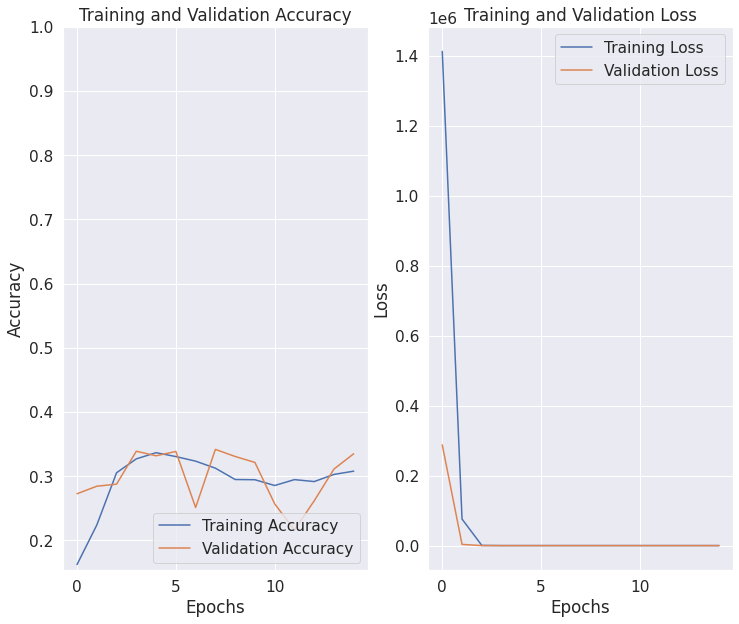

In [ ]:
plot_history(history61,'accuracy','val_accuracy',EPOCHS)

In [ ]:
y_pred61=model_6.predict_classes(test_images)
test_loss, test_acc = model_61.evaluate(test_images,  test_labels, verbose=2)

print('\nTest accuracy:', test_acc)

94/94 - 1s - loss: 1.6003 - accuracy: 0.3343

Test accuracy: 0.3343333303928375


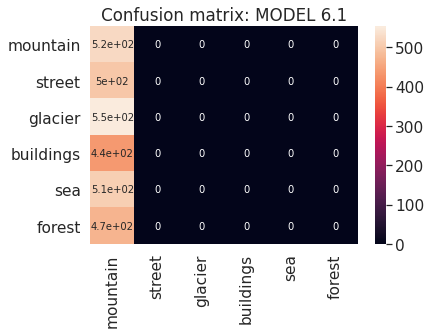


 Recall_score
 [1. 0. 0. 0. 0. 0.]

 Accuracy_score
 0.175

 F1_score
 [0.29787234 0.         0.         0.         0.         0.        ]


/usr/local/lib/python3.6/dist-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


In [ ]:
CM = confusion_matrix(test_labels, y_pred61)
ax = plt.axes()
sn.heatmap(CM, annot=True, 
           annot_kws={"size": 10}, 
           xticklabels=class_names, 
           yticklabels=class_names, ax = ax)
ax.set_title('Confusion matrix: MODEL 6.1')
plt.show()

precision_scoreM61=precision_score(test_labels, y_pred61, average=None)


recall_scoreM61=recall_score(test_labels, y_pred61, average=None)
print("\n Recall_score\n",recall_scoreM6)

accuracy_scoreM61=accuracy_score(test_labels, y_pred61)
print("\n Accuracy_score\n",accuracy_scoreM61)

f1_scoreM61=f1_score(test_labels, y_pred61, average=None)
print("\n F1_score\n",f1_scoreM61)

**MODEL 6.2** 


Fully Forward Neural Network [512-256-128-6]

Activation layers: ReLU, ReLU, ReLU, Softmax

Applied optimization method: Adam

Learning learning: 0.001

Number of epochs: 15

validation_split = 0.2

**Regularization: L1.L2**

In [ ]:
start = time.time()
l1=keras.layers.Dense(512, activation ='relu', kernel_initializer= 'ones', kernel_regularizer=tf.keras.regularizers.L1(0.01), activity_regularizer=tf.keras.regularizers.L2(0.1))
l2=keras.layers.Dense(256, activation ='relu', kernel_initializer= 'ones', kernel_regularizer=tf.keras.regularizers.L1(0.01), activity_regularizer=tf.keras.regularizers.L2(0.1))
l3=keras.layers.Dense(128, activation='relu')
l4=keras.layers.Dense(6, activation='softmax') 
model_62 = keras.Sequential(
[
    keras.layers.Flatten(input_shape=(3,150,150)),
    l1,
    l2,
    l3,
    l4     
])

opt = tf.keras.optimizers.Adam(learning_rate=0.001)
model_62.compile(optimizer=opt,loss='sparse_categorical_crossentropy',metrics=['accuracy'])
EPOCHS = 15
history62 = model_62.fit(train_images, train_labels, batch_size=12, validation_split = 0.2, epochs=EPOCHS)

end = time.time()

Epoch 1/15
936/936 [==============================] - 17s 18ms/step - loss: 29180045312.0000 - accuracy: 0.1584 - val_loss: 5330631168.0000 - val_accuracy: 0.1756
Epoch 2/15
936/936 [==============================] - 17s 18ms/step - loss: 2269181440.0000 - accuracy: 0.1618 - val_loss: 800201408.0000 - val_accuracy: 0.1528
Epoch 3/15
936/936 [==============================] - 17s 18ms/step - loss: 413794208.0000 - accuracy: 0.1597 - val_loss: 189258144.0000 - val_accuracy: 0.1585
Epoch 4/15
936/936 [==============================] - 16s 18ms/step - loss: 107814976.0000 - accuracy: 0.1665 - val_loss: 55644524.0000 - val_accuracy: 0.1649
Epoch 5/15
936/936 [==============================] - 16s 18ms/step - loss: 33450822.0000 - accuracy: 0.1740 - val_loss: 18417162.0000 - val_accuracy: 0.1649
Epoch 6/15
936/936 [==============================] - 17s 18ms/step - loss: 11415954.0000 - accuracy: 0.1837 - val_loss: 6513134.0000 - val_accuracy: 0.2081
Epoch 7/15
936/936 [======================

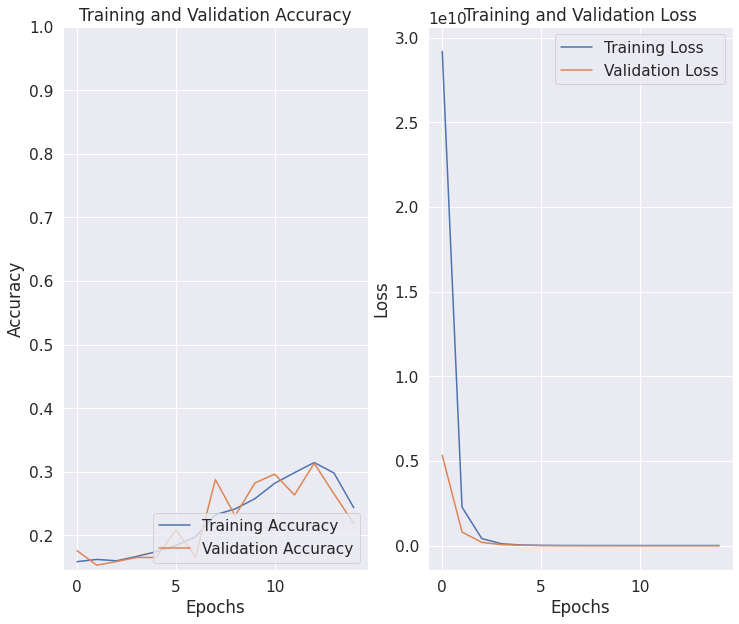

In [ ]:
plot_history(history62,'accuracy','val_accuracy',EPOCHS)

In [ ]:
y_pred62=model_62.predict_classes(test_images)
test_loss, test_acc = model_62.evaluate(test_images,  test_labels, verbose=2)

print('\nTest accuracy:', test_acc)

94/94 - 1s - loss: 16339.0322 - accuracy: 0.2283

Test accuracy: 0.22833333909511566


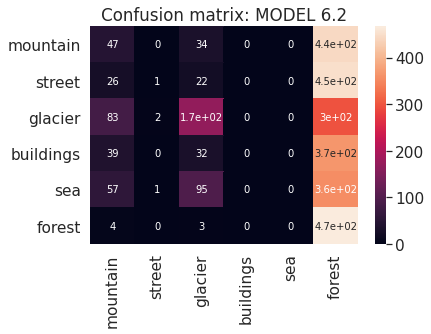


 Recall_score
 [0.08952381 0.00199601 0.3074141  0.         0.         0.98523207]

 Accuracy_score
 0.175

 F1_score
 [0.12035851 0.0039604  0.3740374  0.         0.         0.32680196]


/usr/local/lib/python3.6/dist-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


In [ ]:
CM = confusion_matrix(test_labels, y_pred62)
ax = plt.axes()
sn.heatmap(CM, annot=True, 
           annot_kws={"size": 10}, 
           xticklabels=class_names, 
           yticklabels=class_names, ax = ax)
ax.set_title('Confusion matrix: MODEL 6.2')
plt.show()

precision_scoreM62=precision_score(test_labels, y_pred62, average=None)


recall_scoreM62=recall_score(test_labels, y_pred62, average=None)
print("\n Recall_score\n",recall_scoreM62)

accuracy_scoreM62=accuracy_score(test_labels, y_pred62)
print("\n Accuracy_score\n",accuracy_scoreM61)

f1_scoreM62=f1_score(test_labels, y_pred62, average=None)
print("\n F1_score\n",f1_scoreM62)

**MODEL 6.3**

Fully Forward Neural Network [512-256-128-6]

Activation layers: ReLU, ReLU, ReLU, Softmax

Applied optimization method: Adam

Learning learning: 0.001

Number of epochs: 15

validation_split = 0.2

**Regularization: Dropout**

In [ ]:
start = time.time()
l1=keras.layers.Dense(512, activation ='relu')
l2=keras.layers.Dense(256, activation ='relu')
l3=keras.layers.Dense(128, activation='relu')
l4=keras.layers.Dropout(rate=0.5)
l5=keras.layers.Dense(6, activation='softmax') 
model_63 = keras.Sequential(
[
    keras.layers.Flatten(input_shape=(3,150,150)),
    l1,
    l2,
    l3,
    l4,
    l5     
])

opt = tf.keras.optimizers.Adam(learning_rate=0.001)
model_63.compile(optimizer=opt,loss='sparse_categorical_crossentropy',metrics=['accuracy'])
EPOCHS = 15
history63 = model_63.fit(train_images, train_labels, batch_size=12, validation_split = 0.2, epochs=EPOCHS)

end = time.time()

Epoch 1/15
936/936 [==============================] - 10s 11ms/step - loss: 1.4492 - accuracy: 0.4144 - val_loss: 1.2912 - val_accuracy: 0.4792
Epoch 2/15
936/936 [==============================] - 10s 11ms/step - loss: 1.2599 - accuracy: 0.5087 - val_loss: 1.2445 - val_accuracy: 0.5240
Epoch 3/15
936/936 [==============================] - 10s 11ms/step - loss: 1.1742 - accuracy: 0.5545 - val_loss: 1.1842 - val_accuracy: 0.5461
Epoch 4/15
936/936 [==============================] - 10s 11ms/step - loss: 1.1200 - accuracy: 0.5808 - val_loss: 1.1352 - val_accuracy: 0.5782
Epoch 5/15
936/936 [==============================] - 10s 11ms/step - loss: 1.0766 - accuracy: 0.5971 - val_loss: 1.1194 - val_accuracy: 0.5750
Epoch 6/15
936/936 [==============================] - 10s 11ms/step - loss: 1.0386 - accuracy: 0.6051 - val_loss: 1.1199 - val_accuracy: 0.5846
Epoch 7/15
936/936 [==============================] - 10s 11ms/step - loss: 1.0115 - accuracy: 0.6229 - val_loss: 1.1037 - val_accuracy:

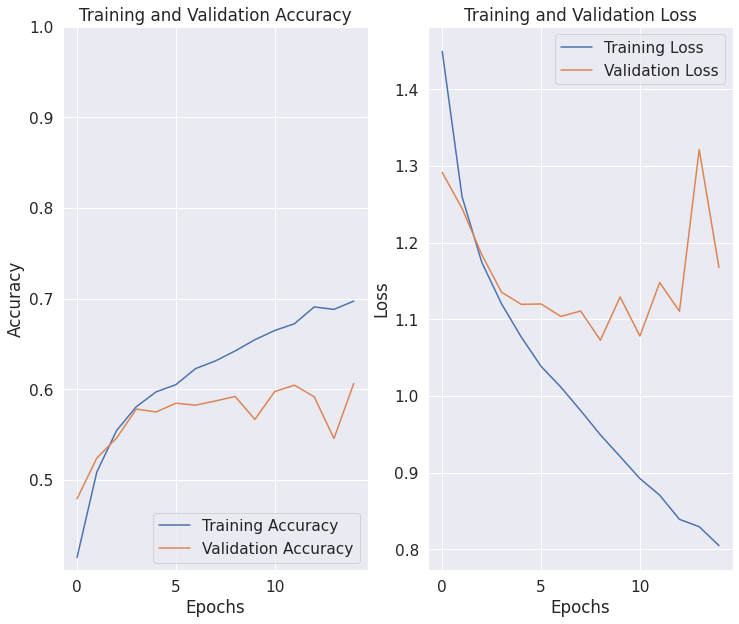

In [ ]:
plot_history(history63,'accuracy','val_accuracy',EPOCHS)

In [ ]:
y_pred63=model_63.predict_classes(test_images)
test_loss, test_acc = model_63.evaluate(test_images,  test_labels, verbose=2)

print('\nTest accuracy:', test_acc)

94/94 - 0s - loss: 1.2262 - accuracy: 0.5817

Test accuracy: 0.5816666483879089


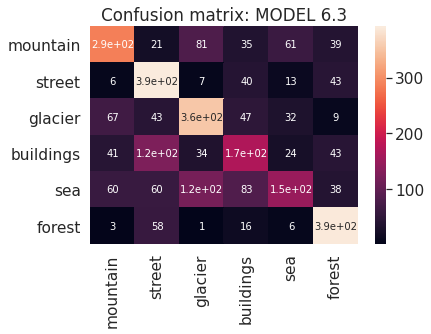


 Recall_score
 [0.54857143 0.78243513 0.64195298 0.38901602 0.29411765 0.82278481]

 Accuracy_score
 0.5816666666666667

 F1_score
 [0.58181818 0.65333333 0.6173913  0.41062802 0.37688442 0.75289575]


In [ ]:
CM = confusion_matrix(test_labels, y_pred63)
ax = plt.axes()
sn.heatmap(CM, annot=True, 
           annot_kws={"size": 10}, 
           xticklabels=class_names, 
           yticklabels=class_names, ax = ax)
ax.set_title('Confusion matrix: MODEL 6.3')
plt.show()

precision_scoreM63=precision_score(test_labels, y_pred63, average=None)


recall_scoreM63=recall_score(test_labels, y_pred63, average=None)
print("\n Recall_score\n",recall_scoreM63)

accuracy_scoreM63=accuracy_score(test_labels, y_pred63)
print("\n Accuracy_score\n",accuracy_scoreM63)

f1_scoreM63=f1_score(test_labels, y_pred63, average=None)
print("\n F1_score\n",f1_scoreM63)

References:

https://www.kaggle.com/uzairrj/beg-tut-intel-image-classification-93-76-accur

https://www.kaggle.com/vincee/intel-image-classification-cnn-keras

https://www.tensorflow.org/api_docs/python/tf/keras/regularizers/L1L2

https://github.com/dhananjaisrmgpc/Neural-Network-based-MNIST-Analysis

